### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load data

In [ ]:
x_train = np.load('/content/drive/MyDrive/ANN2DL_HW2_Shared/original_data/x_train.npy')
y_train = np.load('/content/drive/MyDrive/ANN2DL_HW2_Shared/original_data/y_train.npy')

In [ ]:
label_mapping = {
    "Wish",
    "Another",
    "Comfortably",
    "Money",
    "Breathe",
    "Time",
    "Brain",
    "Echoes",
    "Wearing",
    "Sorrow",
    "Hey",
    "Shine"
}

### Preprocessing

#### Scaling after splitting

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
train_data = np.concatenate([x for x in X_train]) 
scaler = StandardScaler().fit(train_data)

X_train_trans = [] 
for el in X_train: 
  X_train_trans.append(scaler.transform(el))
del X_train 

X_val_trans = [] 
for el in X_val: 
  X_val_trans.append(scaler.transform(el))
del X_val 
# all set

X_train = np.asarray(X_train_trans) 
X_val = np.asarray(X_val_trans) 

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

In [ ]:
scaler.mean_
scaler.var_
scaler.scale_
scaler.n_features_in_
scaler.n_samples_seen_
scaler.with_mean
scaler.with_std
scaler.copy

True

### RNN with GRU (Gated Recurrent Unit)

In [ ]:
def build_RNNGRU(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    dropout = tfkl.Dropout(.4, seed=seed)(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(dropout)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    dropout = tfkl.Dropout(.4, seed=seed)(cnn)

    # GRU
    gru = tfkl.GRU(512, unroll=True, kernel_regularizer=tfk.regularizers.L1L2(l1=1e-4, l2=1e-3))(dropout)

    # Classifier
    classifier = tfkl.Dense(512, activation='relu', kernel_regularizer=tfk.regularizers.L1L2(l1=1e-4, l2=1e-3))(gru)

    output_layer = tfkl.Dense(12, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
input_shape = X_train.shape[1:] # 36,6
batch_size = 128
epochs = 100

In [ ]:
model = build_RNNGRU(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_243 (Conv1D)         (None, 36, 256)           4864      
                                                                 
 conv1d_244 (Conv1D)         (None, 36, 256)           196864    
                                                                 
 max_pooling1d_122 (MaxPooli  (None, 18, 256)          0         
 ng1D)                                                           
                                                                 
 conv1d_245 (Conv1D)         (None, 18, 256)           196864    
                                                                 
 conv1d_246 (Conv1D)         (None, 18, 256)           196864    
                                                             

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 4.7899 - accuracy: 0.3109 - val_loss: 4.1084 - val_accuracy: 0.3498 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 3.6713 - accuracy: 0.3870 - val_loss: 3.2028 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 3.0891 - accuracy: 0.4097 - val_loss: 2.8688 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 2.8708 - accuracy: 0.3757 - val_loss: 2.6685 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 2.5755 - accuracy: 0.4256 - val_loss: 2.4329 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 2.3876 - accuracy: 0.4421 - val_loss: 2.2392 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - lo

### after training

In [ ]:
best_score = max(history['accuracy'])
best_score_val = max(history['val_accuracy'])

print("Max train accuracy obtained with this model:", best_score)
print("Max val accuracy obtained with this model:", best_score_val)

Max train accuracy obtained with this model: 0.8811116814613342
Max val accuracy obtained with this model: 0.6851851940155029


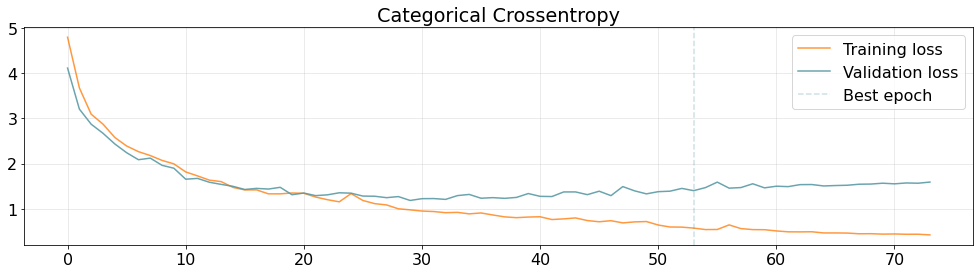

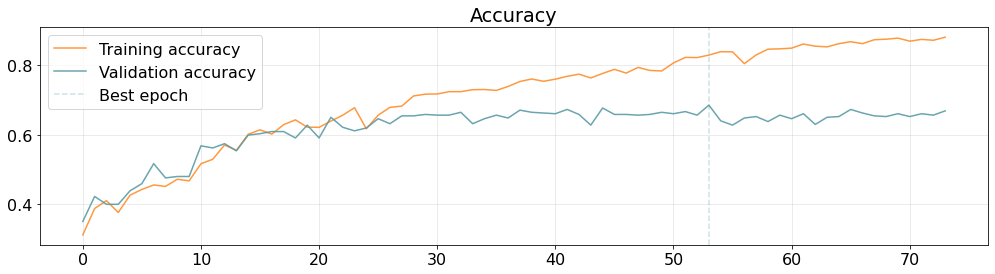

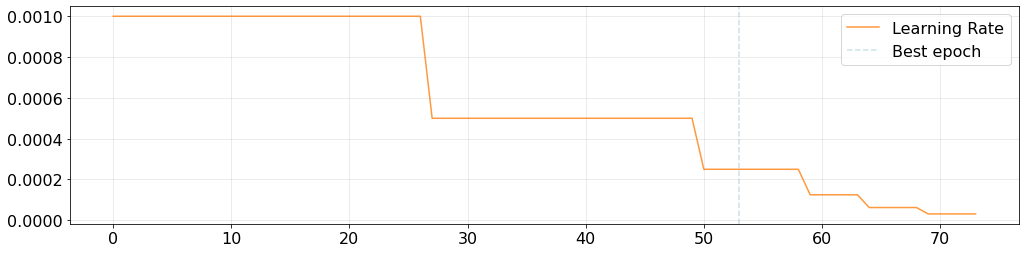

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/ANN2DL_HW2_Shared/nicholas/GRU (1)')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_val)
predictions.shape

16/16 [==============================] - 0s 4ms/step


(486, 12)

Accuracy: 0.6852
Precision: 0.5346
Recall: 0.5425
F1: 0.5138


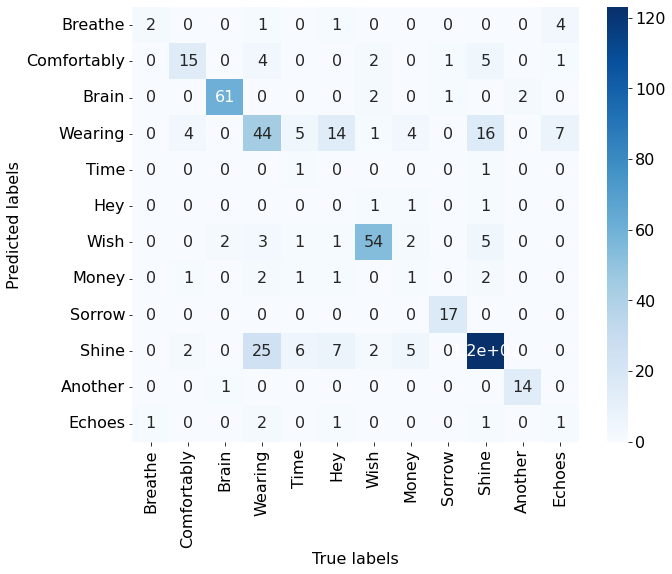

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping), yticklabels=list(label_mapping), annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()